In [3]:
import numpy
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow
import keras
from tensorflow.keras.callbacks import EarlyStopping

2021-09-19 11:42:36.779955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-19 11:42:36.779985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
source_file = '../../../Data/Processed/cenario3/dados_cenario3.csv'
dataframe = pd.read_csv(source_file, delimiter=';', index_col=0, parse_dates=['Data'])

In [5]:
dataframe.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8808 entries, 0 to 8807
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Longitude        8808 non-null   float64       
 1   Latitude         8808 non-null   float64       
 2   Data             8808 non-null   datetime64[ns]
 3   Vento_Magnitude  8808 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 344.1 KB


In [7]:
dataframe.head(3)

,Longitude,Latitude,Data,Vento_Magnitude
0,-42.75,-14.25,2017-01-01 00:00:00,9.815
1,-42.75,-14.25,2017-01-01 01:00:00,8.735
2,-42.75,-14.25,2017-01-01 02:00:00,8.454


In [8]:
df_day = dataframe[['Data', 'Vento_Magnitude']].groupby('Data').mean()
df_day.head(2)

,Vento_Magnitude
Data,
2017-01-01 00:00:00,9.815
2017-01-01 01:00:00,8.735


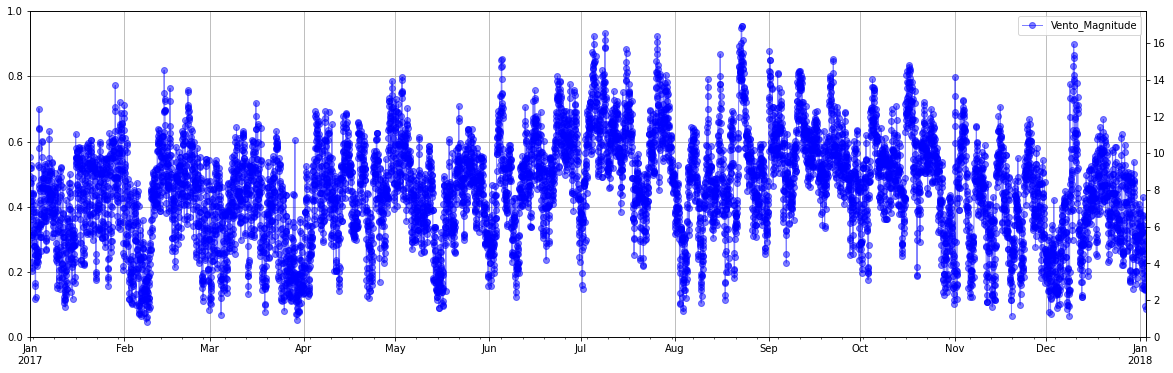

In [9]:
fig = pyplot.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='Vento_Magnitude', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5)
#_ = df_day.plot(y='Temperatura', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [10]:
df_day['V_d1'] = df_day['Vento_Magnitude'].shift(-1)
df_day['V_l1'] = df_day['Vento_Magnitude'].shift(1)
df_day['V_l2'] = df_day['Vento_Magnitude'].shift(2)
df_day['V_l3'] = df_day['Vento_Magnitude'].shift(3)
df_day['V_l4'] = df_day['Vento_Magnitude'].shift(4)
df_day['V_l5'] = df_day['Vento_Magnitude'].shift(5)
df_day['V_l6'] = df_day['Vento_Magnitude'].shift(6)
df_day['V_l7'] = df_day['Vento_Magnitude'].shift(7)

complete_cases = ~df_day.isna().any(axis=1)
dfn = df_day[complete_cases]

In [11]:
df_day.head(5)

,Vento_Magnitude,V_d1,V_l1,V_l2,V_l3,V_l4,V_l5,V_l6,V_l7
Data,,,,,,,,,
2017-01-01 00:00:00,9.815,8.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,8.735,8.454,9.815,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,8.454,9.178,8.735,9.815,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,9.178,9.186,8.454,8.735,9.815,NaN,NaN,NaN,NaN
2017-01-01 04:00:00,9.186,9.361,9.178,8.454,8.735,9.815,NaN,NaN,NaN


In [34]:
# TRAINING
n_test_samples = 30
n_validation_samples = 30
random_seed = 32

# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

x_cols = ['Vento_Magnitude', 'V_l1','V_l2','V_l3','V_l4','V_l5','V_l6','V_l7']
y_cols = ['V_d1']

# SAMPLING
X_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][x_cols].to_numpy()
X_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][x_cols].to_numpy()
X_tst = dfn[x_cols].to_numpy()
Y_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][y_cols].to_numpy()
Y_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][y_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_trn)
X_trn_scaled = X_scaler.transform(X_trn)
X_val_scaled = X_scaler.transform(X_val)
X_tst_scaled = X_scaler.transform(X_tst)

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y_trn)
Y_trn_scaled = Y_scaler.transform(Y_trn)
Y_val_scaled = Y_scaler.transform(Y_val)

# DECLARE NET
max_neurons = 20
PATIENCE = 250
MAX_EPOCHS = 10*PATIENCE
LEARNING_RATE = 0.01
HIDDEN_ACTIVATION = 'relu'
MODEL_LOSS = 'val_loss'
MIN_IMPROVEMENT = 0.025

best_loss = 1000.0
best_val_loss = 1000.0
training_result_list = []
for n_neurons in numpy.arange(max_neurons) + 1:
    
    inputs = keras.Input(shape=(X_trn_scaled.shape[1]))
    hidden = keras.layers.Dense(n_neurons, activation=HIDDEN_ACTIVATION)(inputs)
    outputs = keras.layers.Dense(Y_trn_scaled.shape[1], activation='linear')(hidden)
    model_name = 'FORECAST_{}_QTD_NEURONS_{}'.format(HIDDEN_ACTIVATION, n_neurons)
    print(f'Modelo: {model_name}')
    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    #incluido tensorflow.keras... sem dá erro dizendo que opt do keras não tem Adam
    my_net.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    history = my_net.fit(X_trn_scaled, Y_trn_scaled, epochs=MAX_EPOCHS, validation_data=(X_val_scaled, Y_val_scaled), batch_size=X_trn_scaled.shape[0], callbacks=[es_callback], verbose=0)
    model_loss = history.history['loss'][-1]
    model_val_loss = history.history['val_loss'][-1]
    epochs = len(history.history['val_loss'])

    has_improved_val_loss = False
    loss_improvement = 1.0 - model_val_loss/best_val_loss

    if loss_improvement >= MIN_IMPROVEMENT:
        is_best_net = ((model_loss <= best_loss) & (model_val_loss < best_val_loss))

        if is_best_net:
                best_loss = model_loss
                best_val_loss = model_val_loss
                best_net = my_net
                best_history = history
                best_text = '***BEST NET!***'
                improvement_text = '{:.0f}% GAIN'.format(100.0*loss_improvement)
                best_name = model_name
                best_epochs = epochs
        else:
            best_text = ''
            improvement_text = ''
    else:
        print('EXTRA NEURON DIDNT IMPROVE NET {:.0f}% GAIN'.format(100.0*loss_improvement))
        break
    
    result_dict = {'model_name': model_name, 'epochs': epochs, 'model_loss': model_loss, 'model_val_loss': model_val_loss, 'best_net':is_best_net}
    
    
    training_result_list.append(result_dict)
    print('{} RESULTS > EPOCHS: {} LOSS: {:.3f} VAL_LOSS: {:.3f} {} {}'.format(model_name, epochs, model_loss, model_val_loss, best_text, improvement_text)) 

Modelo: FORECAST_relu_QTD_NEURONS_1
FORECAST_relu_QTD_NEURONS_1 RESULTS > EPOCHS: 1081 LOSS: 0.099 VAL_LOSS: 0.074 ***BEST NET!*** 100% GAIN
Modelo: FORECAST_relu_QTD_NEURONS_2
EXTRA NEURON DIDNT IMPROVE NET -4% GAIN


In [35]:
Y_est_scaled = best_net.predict(X_tst_scaled)

Y_est = Y_scaler.inverse_transform(Y_est_scaled)


df_day.loc[complete_cases, ['Y_est']] = Y_est
df_day['residual'] = df_day['Y_est'] - df_day['V_d1']
df_day['rabs'] = df_day['residual'].abs()


model_r2_score = r2_score(df_day.loc[complete_cases, 'V_d1'].to_numpy(), df_day.loc[complete_cases, 'Y_est'].to_numpy())


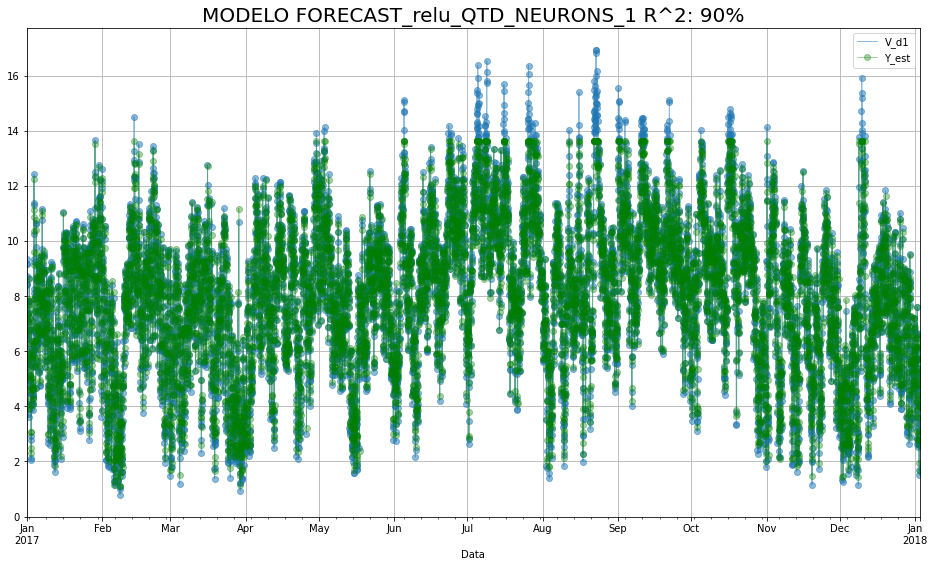

In [36]:
fig = pyplot.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
_ = df_day.plot(y='V_d1', ax=ax, lw=1, marker='o', alpha=0.5)
_ = df_day.plot(y='Y_est', ax=ax, lw=1, marker='o', alpha=0.35, color='green')
_ = ax.grid()
_ = ax.set_title('MODELO {} R^2: {:.0f}%'.format(best_name, 100.0*model_r2_score), size=20)

In [37]:
df_day.sort_values('rabs', ascending=True)

,Vento_Magnitude,V_d1,V_l1,V_l2,V_l3,V_l4,V_l5,V_l6,V_l7,Y_est,residual,rabs
Data,,,,,,,,,,,,
2017-05-25 16:00:00,8.372,8.312,8.753,9.684,9.669,9.396,9.330,9.418,9.015,8.312140,0.000140,0.000140
2017-07-18 18:00:00,8.102,8.277,7.158,5.368,5.317,4.446,5.950,6.264,6.685,8.277186,0.000186,0.000186
2017-01-25 05:00:00,9.678,9.577,8.915,8.433,7.846,7.982,9.102,9.178,6.140,9.576813,-0.000187,0.000187
2017-11-18 04:00:00,5.560,5.744,5.425,6.235,6.912,7.883,9.100,9.316,8.798,5.743743,-0.000257,0.000257
2017-12-23 10:00:00,7.768,7.805,7.775,7.428,6.974,7.763,8.250,8.612,8.880,7.805348,0.000348,0.000348
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01 03:00:00,9.178,9.186,8.454,8.735,9.815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00,9.186,9.361,9.178,8.454,8.735,9.815,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 05:00:00,9.361,8.403,9.186,9.178,8.454,8.735,9.815,NaN,NaN,NaN,NaN,NaN


In [38]:
output_file = '../../../Data/Processed/cenario3/predicao_cenario3.csv'
df_day.to_csv(output_file, sep=';', encoding='utf-8')

<h3>Exportação do modelo da rede neural</3>

In [40]:
from keras.models import load_model

# EXPOTACAO DO MODELO
model_file = '../../../Code/Model/cenario3/modelo_C3_FFW'

tensorflow.keras.models.save_model(best_net, model_file)

INFO:tensorflow:Assets written to: ../../../Code/Model/cenario3/modelo_C3_FFW/assets


In [41]:
## IMPORTACAO DO MODELO
#model = load_model(model_file)

## TESTE DO MODELO IMPORTADO
#model.predict(numpy.array(numpy.array([[1,10,11,13,10,12,13,29]]))